<a href="https://colab.research.google.com/github/mshilpaa/machine_learning/blob/master/Mask_Depth_Prediction/MSELoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-rjzxapir
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-rjzxapir
     |████████████████████████████████| 634kB 2.8MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65038 sha256=90b7408ac3e8339b60691d88a0c81147f8b3f3acb6e89a80315568026ec1cc93
  Stored in directory: /tmp/pip-ephem-wheel-cache-vh0z7lvm/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=0f1877919dac655d45125f67d405dbc57cc26e1a85782b478cd474a854fc3dc8
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
  

In [0]:
%load_ext tensorboard

In [4]:
! pip install kornia

     |████████████████████████████████| 163kB 2.7MB/s 


In [5]:
! pip install memory_profiler
%load_ext memory_profiler

  Created wheel for memory-profiler: filename=memory_profiler-0.57.0-cp36-none-any.whl size=28992 sha256=ee4af204e8f0e7662dc5cf440da58b79afbecd5d9fc2434f9e7927b8d7e24d79
  Stored in directory: /root/.cache/pip/wheels/74/20/b5/20964ef97be73d2c3a695c9cad7bccd96d1e3e737a8163861f
Successfully built memory-profiler


In [0]:
import os
from zipfile import ZipFile 
import torch
import numpy as np
from PIL import Image
from matplotlib.image import imread
import matplotlib.pyplot as plt
import sys

In [7]:
!pip install torchsummary

import torch
from torchsummary import summary

In [8]:
# if ['data_1','data_2','data_3','data_4','data_5'] in os.listdir('/content'):
#   print('data already downloaded')
# else:
for i in os.listdir('/content/gdrive/My Drive/Mask_Rcnn/Dataset'):
  filename = f'/content/gdrive/My Drive/Mask_Rcnn/Dataset/{i}'
  print(filename)
# opening the zip file in READ mode 
  with ZipFile(filename, 'r') as zip_file: 
      # printing all the contents of the zip file 
      #zip.printdir() 
    
      # extracting all the files 
      print('Extracting all the files now...') 
      zip_file.extractall() 
      print('Done!')


/content/gdrive/My Drive/Mask_Rcnn/Dataset/data_part1.zip
Extracting all the files now...
Done!
/content/gdrive/My Drive/Mask_Rcnn/Dataset/data_part2.zip
Extracting all the files now...
Done!
/content/gdrive/My Drive/Mask_Rcnn/Dataset/data_part3.zip
Extracting all the files now...
Done!
/content/gdrive/My Drive/Mask_Rcnn/Dataset/data_part4.zip
Extracting all the files now...
Done!
/content/gdrive/My Drive/Mask_Rcnn/Dataset/data_part5.zip
Extracting all the files now...
Done!


In [0]:
# %%file mprun_customdata.py

import torch
from skimage import io
import numpy as np
from torch.utils.data import Dataset
import random
def get_data(label_file='/content/gdrive/My Drive/Mask_Rcnn/labels.txt'):
    fg_bg = []
    bg = []
    mask = []
    depth_img = []
    labels = (open(label_file,'r')).readlines()[:100000]
    for label in labels:
      a  = label.split('\t')
      bg.append(f'/content/gdrive/My Drive/Mask_Rcnn/{a[0]}')
      fg_bg.append(f'/content/{a[2]}')         
      mask.append(f'/content/{a[3]}')
      depth = a[4].split('\n')[0]
      depth_img.append(f'/content/{depth}')
    dataset =  list(zip(bg,fg_bg,mask,depth_img))
    random.shuffle(dataset)
    train_split = 70
    train_len = len(dataset)*train_split//100
    train = dataset[:train_len]
    test = dataset[train_len:]
    return train,test
      
class CustomDataset(Dataset):
    def __init__(self, data, transform=None,mask_transform=None,depth_transform=None):
        self.transform = transform
        self.bg,self.fg_bg,self.mask,self.depth_img = zip(*data)
        # self.mask_transform = A.Compose([ A.Normalize(mean=(0.04608837, 0.04608837, 0.04608837)	, 
        #                                                 std=(0.20544916, 0.20544916, 0.20544916)),
        #                                    AP.ToTensor()])
        # self.depth_transform = A.Compose([ A.Normalize(mean=(0.50911522, 0.50911522, 0.50911522)	, 
        #                                                 std=(0.28174302, 0.28174302, 0.28174302)),
        #                                    AP.ToTensor()])

        self.mask_transform = mask_transform
        self.depth_transform = depth_transform

    def __len__(self):
        return len(self.fg_bg)

    def __getitem__(self, idx):
  
        # print(self.fg_bg[idx],'---',idx,'----')
        bg = np.asarray(Image.open(self.bg[idx]))
        fg_bg = np.asarray(Image.open(self.fg_bg[idx]))
        mask = np.asarray(Image.open(self.mask[idx]))
        depth = np.asarray(Image.open(self.depth_img[idx]))

        if self.mask_transform:
          img = mask
          if(len(img.shape) ==2):         
                img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

          mask = self.mask_transform(image= img )['image']

        if self.depth_transform:
          img=depth
          if(len(img.shape) ==2):         
                img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
          depth = self.depth_transform(image= img )['image']

        if self.transform:
            bg = self.transform(image=bg)['image']
            fg_bg = self.transform(image=fg_bg)['image']
        
        return bg,fg_bg,mask,depth

In [0]:
import albumentations as A
import albumentations.pytorch as AP
from torch.utils.data import random_split
mean =  (0.65830478, 0.61511271, 0.5740604 )
std = (0.24408717, 0.2542491, 0.26870159)
	
train_transform = A.Compose(
    [ 
   
     A.Resize(64, 64, interpolation=1, always_apply=True, p=1), 
     A.Cutout(num_holes=2, max_h_size=16,max_w_size = 16,p=1,fill_value=0.6*255), 
     A.Normalize(mean=mean, std=std),
     AP.ToTensor()        
             ])
            
test_transform = A.Compose(
    [ 
     A.Resize(64, 64, interpolation=1, always_apply=True, p=1),
     AP.ToTensor()        
             ])


train_target_transform =  A.Compose(
    [ 
     A.Resize(64, 64, interpolation=1, always_apply=True, p=1),
     AP.ToTensor()        
             ])

test_target_transform =  A.Compose(
    [ 
     A.Resize(64, 64, interpolation=1, always_apply=True, p=1),
     AP.ToTensor()        
             ])

train, test = get_data()


train_set = CustomDataset(train,transform=train_transform ,mask_transform=train_target_transform, depth_transform=train_target_transform)
test_set = CustomDataset(test,transform=test_transform ,mask_transform=test_target_transform, depth_transform=test_target_transform)

In [11]:
print(len(train_set))
print(len(test_set))

70000
30000


In [0]:
# %%file mprun_load.py
import torch
import torchvision



def load(trainset,testset,seed=1,batch_size=128,num_workers=4,pin_memory=True):
	
	SEED = 1

	# CUDA?
	cuda = torch.cuda.is_available()


	# For reproducibility
	torch.manual_seed(SEED)

	if cuda:
			torch.cuda.manual_seed(SEED)

	# dataloader arguments - something you'll fetch these from cmdprmt
	dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory) if cuda else dict(shuffle=True, batch_size=64)

	trainloader = torch.utils.data.DataLoader(train_set, **dataloader_args)
	testloader = torch.utils.data.DataLoader(test_set, **dataloader_args)


	return  trainloader, testloader

In [0]:
trainloader,testloader = load(train_set,test_set,batch_size=128)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Resnet_Block(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Resnet_Block, self).__init__()
        # Input Block

        self.conv1 = nn.Sequential(
          
          nn.BatchNorm2d(in_channels),
          nn.ReLU(),
          nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=False), 
          
          nn.BatchNorm2d(out_channels),
          nn.ReLU(),
          nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=False), 
      )
        
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1, 1), padding=0, bias=False),
        )

    def forward(self,x):
      out = self.conv1(x)
      
      one = self.shortcut(x)
      # print(out.size(),x.size(),one.size())
      out += one
      return out

class Downsample(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Downsample, self).__init__()
        # Input Block
        
        self.conv1 = nn.Sequential(
          
          nn.BatchNorm2d(in_channels),
          nn.ReLU(),
          nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=False,stride=2), 
          
          # nn.BatchNorm2d(out_channels),
          # nn.ReLU(),
          # nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=False), 
      )
        
        # self.shortcut = nn.Sequential(
        #     nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1, 1), padding=0, bias=False,stride=2),
        # )

    def forward(self,x):
      out = self.conv1(x)
      
      # one = self.shortcut(x)
      # print('---',out.size(),x.size(),one.size())
      # out += one
      return out

class Upsample(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Upsample, self).__init__()
        # Input Block
        
        self.conv1 = nn.Sequential(
          
          nn.BatchNorm2d(in_channels),
          nn.ReLU(),
          nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(2, 2), padding=0, bias=False,stride=2), 
          
          # nn.BatchNorm2d(out_channels),
          # nn.ReLU(),
          # nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=False), 
      )
        
        # self.shortcut = nn.Sequential(
        #     nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1, 1), padding=0, bias=False,stride=2),
        # )

    def forward(self,x):
      out = self.conv1(x)
      
      # one = self.shortcut(x)
      # print('---',out.size(),x.size(),one.size())
      # out += one
      return out
       

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block

        self.conv1 = nn.Conv2d(in_channels=6, out_channels=32, kernel_size=(3, 3), padding=1, bias=False)
      
       
        self.enc1 = Resnet_Block(32,32)
        self.enc2 = Resnet_Block(64,64)
        self.enc3 = Resnet_Block(64,64)
        self.enc4 = Resnet_Block(128,128)
        self.enc5 = Resnet_Block(128,128)

        self.enc1_down = Downsample(32,64)       
        self.enc2_down = Downsample(64,64)
        self.enc3_down = Downsample(64,128)
        self.enc4_down = Downsample(128,128)

        self.dec1_1 = Resnet_Block(32,3) 
        self.dec1 = Resnet_Block(64,32)
        self.dec2 = Resnet_Block(128,64)
        self.dec3 = Resnet_Block(128,64)
        self.dec4 = Resnet_Block(256,128)
        # self.dec5 = Resnet_Block(128,128)


        self.dec1_up = Upsample(64,32)       
        self.dec2_up = Upsample(64,64)
        self.dec3_up = Upsample(128,64)
        self.dec4_up = Upsample(128,128)


        self.Mdec1_1 = Resnet_Block(32,3) 
        self.Mdec1 = Resnet_Block(64,32)
        self.Mdec2 = Resnet_Block(128,64)
        self.Mdec3 = Resnet_Block(128,64)
        self.Mdec4 = Resnet_Block(256,128)
        # self.Mdec5 = Resnet_Block(128,128)


        self.Mdec1_up = Upsample(64,32)       
        self.Mdec2_up = Upsample(64,64)
        self.Mdec3_up = Upsample(128,64)
        self.Mdec4_up = Upsample(128,128)

        self.sigmoid = nn.LogSigmoid()

    def forward(self,x):

      out1 = self.conv1(x)       # o/p 32x64x64
      # print('out1',out1.size())
      en1 = self.enc1(out1)       # 32x64x64
      # print('en1',en1.size())
      en1_1 = self.enc1_down(en1)   # 64x32x32
      # print('en1_1',en1_1.size())
      en2 = self.enc2(en1_1)       # 64x32x32
      # print('en2',en2.size())
      en2_1 = self.enc2_down(en2)  # 64x16x16
      # print('en2_1',en2_1.size())
      en3 = self.enc3(en2_1)       # 64x16x16
      # print('en3',en3.size())
      en3_1 = self.enc3_down(en3)  # 128x8x8
      # print('en3_1',en3_1.size())

      en4 = self.enc4(en3_1)       # 128x8x8
      # print('en4',en4.size())
      en4_1 = self.enc4_down(en4)  # 128x4x4
      # print('en4_1',en4_1.size())

      en5 = self.enc5(en4_1)       # 128x4x4
      # print('en5',en5.size())

# depth
      de4 = self.dec4_up(en5)     # 128x8x8
      # print('de4',de4.size())
      de4_1 = torch.cat((en4,de4 ),1)             # 256x8x8
      # print('de4_1',de4_1.size())

      de4_1 = self.dec4(de4_1)  # 128x8x8
      # print('de4_1',de4_1.size())

      de3 = self.dec3_up(de4_1)  # 64x16x16
      # print('de3',de3.size())
      de3_1 = torch.cat((en3,de3 ),1)                 # 128x16x16
      # print('de3_1',de3_1.size())

      de3_1 = self.dec3(de3_1)   # 64x16x16
      # print('de3_1',de3_1.size())
      
      de2 = self.dec2_up(de3_1)  # 64x32x32
      # print('de2',de2.size())

      de2_1 = torch.cat((en2,de2 ),1)         # 128x32x32
      # print('de2_1',de2_1.size())

      de2_1 = self.dec2(de2_1)  # 64x32x32
      # print('de2_1',de2_1.size())
      
      de1 = self.dec1_up(de2_1) # 32x64x64
      # print('de1',de1.size())
      de1_1 = torch.cat((en1,de1),1) # 64x64x64
      # print('de1_1',de1_1.size())

      de1_1 = self.dec1(de1_1) # 32x64x64
      # print('de1_1',de1_1.size())
      de1_2 = self.dec1_1(de1_1) # 3x64x64
      # print('de1_2',de1_2.size())
    

# mask

      Mde4 = self.Mdec4_up(en5)     # 128x8x8
      # print('Mde4',Mde4.size())
      Mde4_1 = torch.cat((en4,Mde4 ),1)             # 256x8x8
      # print('Mde4_1',Mde4_1.size())

      Mde4_1 = self.Mdec4(Mde4_1)  # 128x8x8
      # print('Mde4_1',Mde4_1.size())

      Mde3 = self.Mdec3_up(Mde4_1)  # 64x16x16
      # print('Mde3',Mde3.size())
      Mde3_1 = torch.cat((en3,Mde3 ),1)                 # 128x16x16
      # print('Mde3_1',Mde3_1.size())

      Mde3_1 = self.Mdec3(Mde3_1)   # 64x16x16
      # print('Mde3_1',Mde3_1.size())
      
      Mde2 = self.Mdec2_up(Mde3_1)  # 64x32x32
      # print('Mde2',Mde2.size())

      Mde2_1 = torch.cat((en2,Mde2 ),1)         # 128x32x32
      # print('Mde2_1',Mde2_1.size())

      Mde2_1 = self.Mdec2(Mde2_1)  # 64x32x32
      # print('Mde2_1',Mde2_1.size())
      
      Mde1 = self.Mdec1_up(Mde2_1) # 32x64x64
      # print('Mde1',Mde1.size())
      Mde1_1 = torch.cat((en1,Mde1),1) # 64x64x64
      # print('Mde1_1',Mde1_1.size())

      Mde1_1 = self.Mdec1(Mde1_1) # 32x64x64
      # print('Mde1_1',Mde1_1.size())
      Mde1_2 = self.Mdec1_1(Mde1_1) # 3x64x64
      # print('Mde1_2',Mde1_2.size())


      # print('final ',out3.size(),out4.size())

      return Mde1_2, de1_2  # mask,depth





In [15]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)

cuda


In [16]:
summary(model, input_size=(6, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           1,728
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           9,216
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 32, 64, 64]           9,216
            Conv2d-8           [-1, 32, 64, 64]           1,024
      Resnet_Block-9           [-1, 32, 64, 64]               0
      BatchNorm2d-10           [-1, 32, 64, 64]              64
             ReLU-11           [-1, 32, 64, 64]               0
           Conv2d-12           [-1, 64, 32, 32]          18,432
       Downsample-13           [-1, 64, 32, 32]               0
      BatchNorm2d-14           [-1, 64,

In [17]:
# from torch.utils.tensorboard import SummaryWriter
# tb = SummaryWriter()
# bg,fgbg,mask,depth = next(iter(trainloader))
# data = torch.cat((fgbg,bg),1).to(device)
# tb.add_graph(model(data))
# tb.close()

AttributeError: ignored

In [0]:
%tensorboard --logdir=runs 

In [0]:
import torch.optim as optim
from torch.optim import lr_scheduler
from kornia.losses import SSIM

In [19]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)

cuda


In [0]:
# criterion1 = nn.BCEWithLogitsLoss()
criterion1 = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
# criterion1 = SSIM(window_size=3, reduction= 'mean')
# criterion2 = SSIM(window_size=3, reduction= 'mean')
criterion2 = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
schedular = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, last_epoch=-1)
# optimizer = optim.Adam(model.parameters(), lr=0.01, eps=1e-08, weight_decay=0.9, amsgrad=False)
# schedular = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=False, 
#                                            threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

| criterion1   | criterion2 |   init_loss  |  end_loss|            epochs |
| -- | -- | -- | -- | --|
| bcewithlogits | bcewithlogits |  0.6 | 0.54     | 20 epochs |
| bcewithlogits | ssim          |  0.21 | 0.067  | 20 epochs |
|  ssim | ssim | 0.19 | 0.075 | 20 |
| MSELoss | ssim | 0.16 | 0.04 | 20 |
|   |  |  |  |  |
|   |  |  |  |  |
|   |  |  |  |  |

MSELoss produces blur imgs even though loss is low


In [21]:

train_losses = []
test_losses = []
train_acc = []
test_acc = []
train_acc_epoch_end = []
train_loss_epoch_end = []

for epoch in range(20):  # loop over the dataset multiple times

    import torch
    #Training & Testing Loops
    from tqdm import tqdm

    model.train()
    pbar = tqdm(trainloader)
    correct = 0
    processed = 0
    for batch_idx, (bg,fg_bg,mask,depth) in enumerate(pbar):
      # get samples
      data = torch.cat((fg_bg,bg),1)
      
      data,mask,depth = data.to(device), mask.to(device), depth.to(device)
      # print(data.shape,mask.shape)
      # Init
      optimizer.zero_grad()
      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
      # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

      # Predict
      mask_pred, depth_pred = model(data)

      # Calculate loss
      #loss = F.nll_loss(y_pred, target)
      # print(y_pred.shape,mask.shape)
      loss1 = criterion1(mask_pred, mask)
      loss2 =  criterion2(depth_pred, depth) 
      loss = (loss1 + loss2)/2
      train_losses.append(loss)

      # Backpropagation
      loss.backward()
      optimizer.step()

      # Update pbar-tqdm
      
      # pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      # correct += pred.eq(target.view_as(pred)).sum().item()
      # processed += len(data)
      lr = optimizer.param_groups[0]['lr']
      pbar.set_description(desc= f'Epoch= {epoch+1} LR= {lr} Mask Loss={loss1.item()} Depth Loss={loss2.item()} Loss={loss.item()} Batch_id={batch_idx}')
    #   train_acc.append(100*correct/processed)
    # train_acc_epoch_end.append(train_acc[-1])
    train_loss_epoch_end.append(train_losses[-1])
    schedular.step()

print('Finished Training')

Epoch= 1 LR= 0.01 Mask Loss=0.02643485926091671 Depth Loss=0.020175766199827194 Loss=0.023305311799049377 Batch_id=546: 100%|██████████| 547/547 [09:03<00:00,  1.01it/s]
Epoch= 2 LR= 0.01 Mask Loss=0.017730869352817535 Depth Loss=0.013438443653285503 Loss=0.015584656968712807 Batch_id=546: 100%|██████████| 547/547 [08:27<00:00,  1.08it/s]
Epoch= 3 LR= 0.01 Mask Loss=0.01334741897881031 Depth Loss=0.01152793038636446 Loss=0.012437675148248672 Batch_id=546: 100%|██████████| 547/547 [08:31<00:00,  1.07it/s]
Epoch= 4 LR= 0.01 Mask Loss=0.013647022657096386 Depth Loss=0.010842299088835716 Loss=0.012244660407304764 Batch_id=546: 100%|██████████| 547/547 [08:40<00:00,  1.05it/s]
Epoch= 5 LR= 0.01 Mask Loss=0.012164185754954815 Depth Loss=0.009690534323453903 Loss=0.010927360504865646 Batch_id=546: 100%|██████████| 547/547 [08:57<00:00,  1.02it/s]
Epoch= 6 LR= 0.01 Mask Loss=0.010909595526754856 Depth Loss=0.008374324068427086 Loss=0.009641960263252258 Batch_id=546: 100%|██████████| 547/547 [0

KeyboardInterrupt: ignored

In [0]:
def show_images(actual,predicted,title=''):
  import torchvision
  img1 = torchvision.utils.make_grid(actual.detach().cpu(),8)
  img1_1 = img1.permute(1,2,0)


  img2 = torchvision.utils.make_grid(predicted.detach().cpu(),8)
  img2_1 = img2.permute(1,2,0)

  fig, axs = plt.subplots(1,2,figsize=(25,25))
  axs[0].imshow(img1_1)
  axs[0].set_title(f'Actual {title}')
  axs[1].imshow(img2_1)
  axs[1].set_title(f'Predicted {title}')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


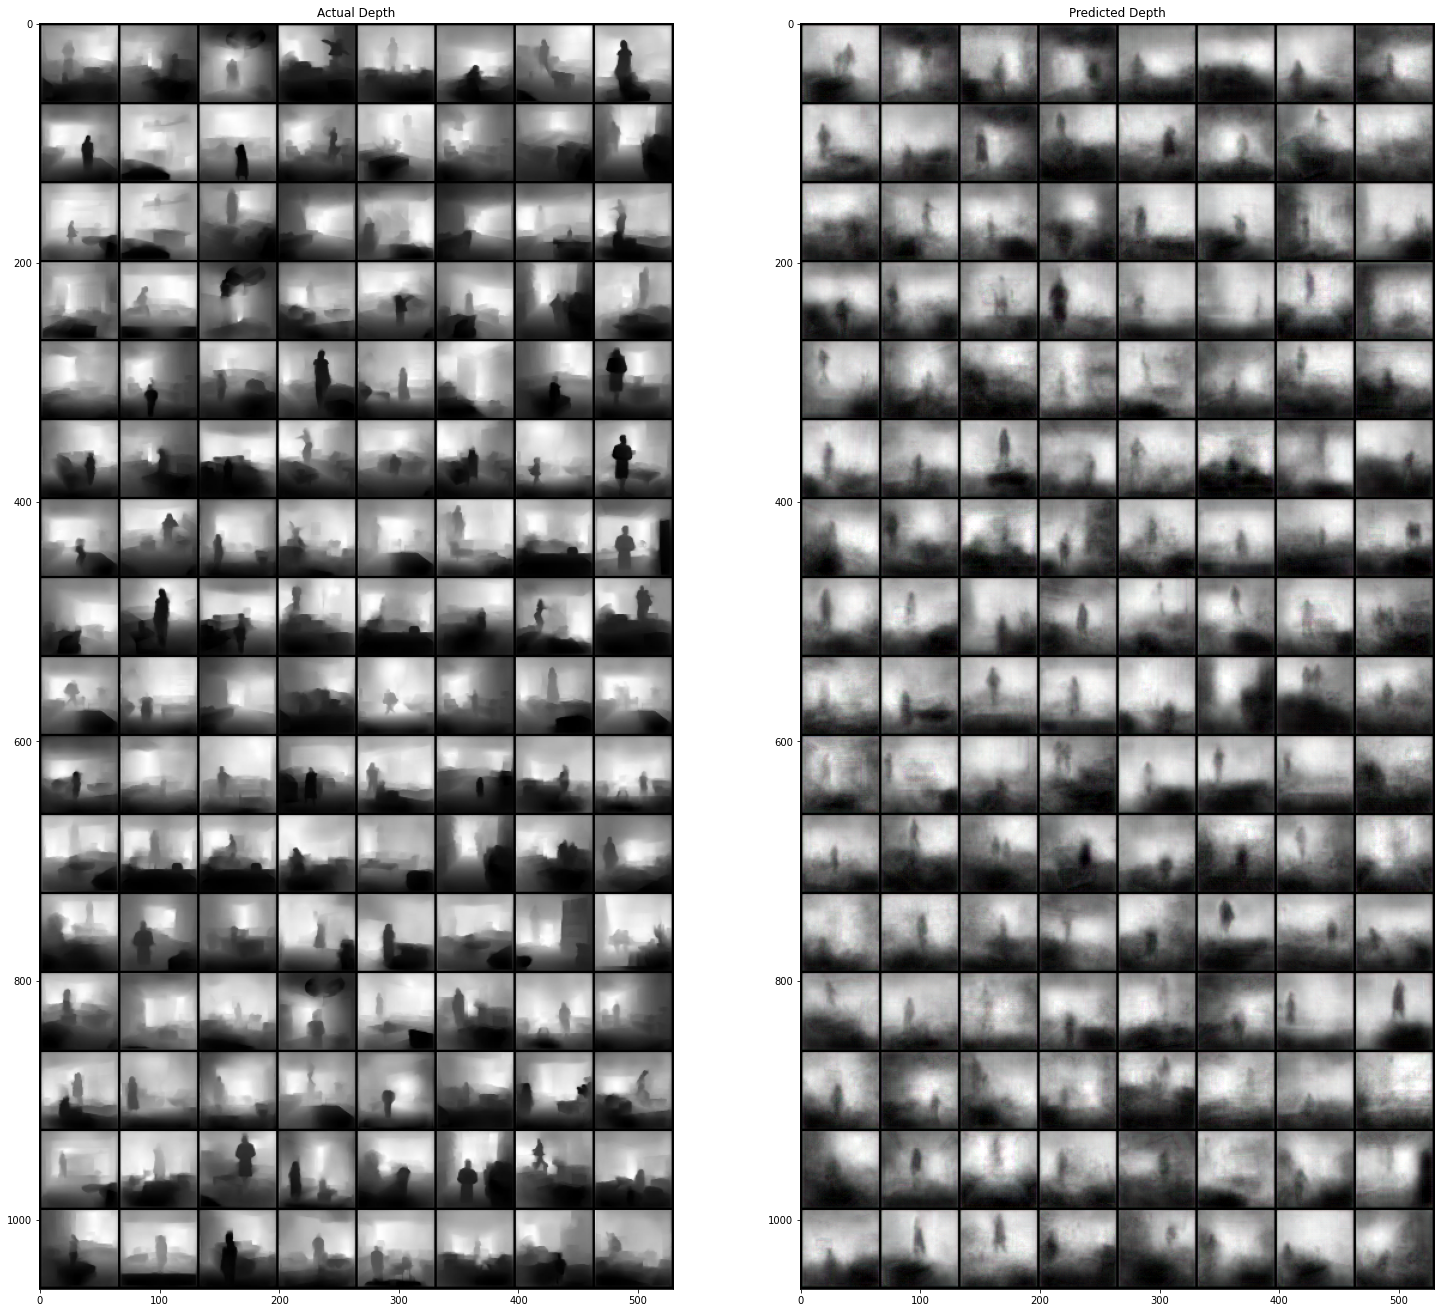

In [23]:
show_images(depth,depth_pred,title='Depth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


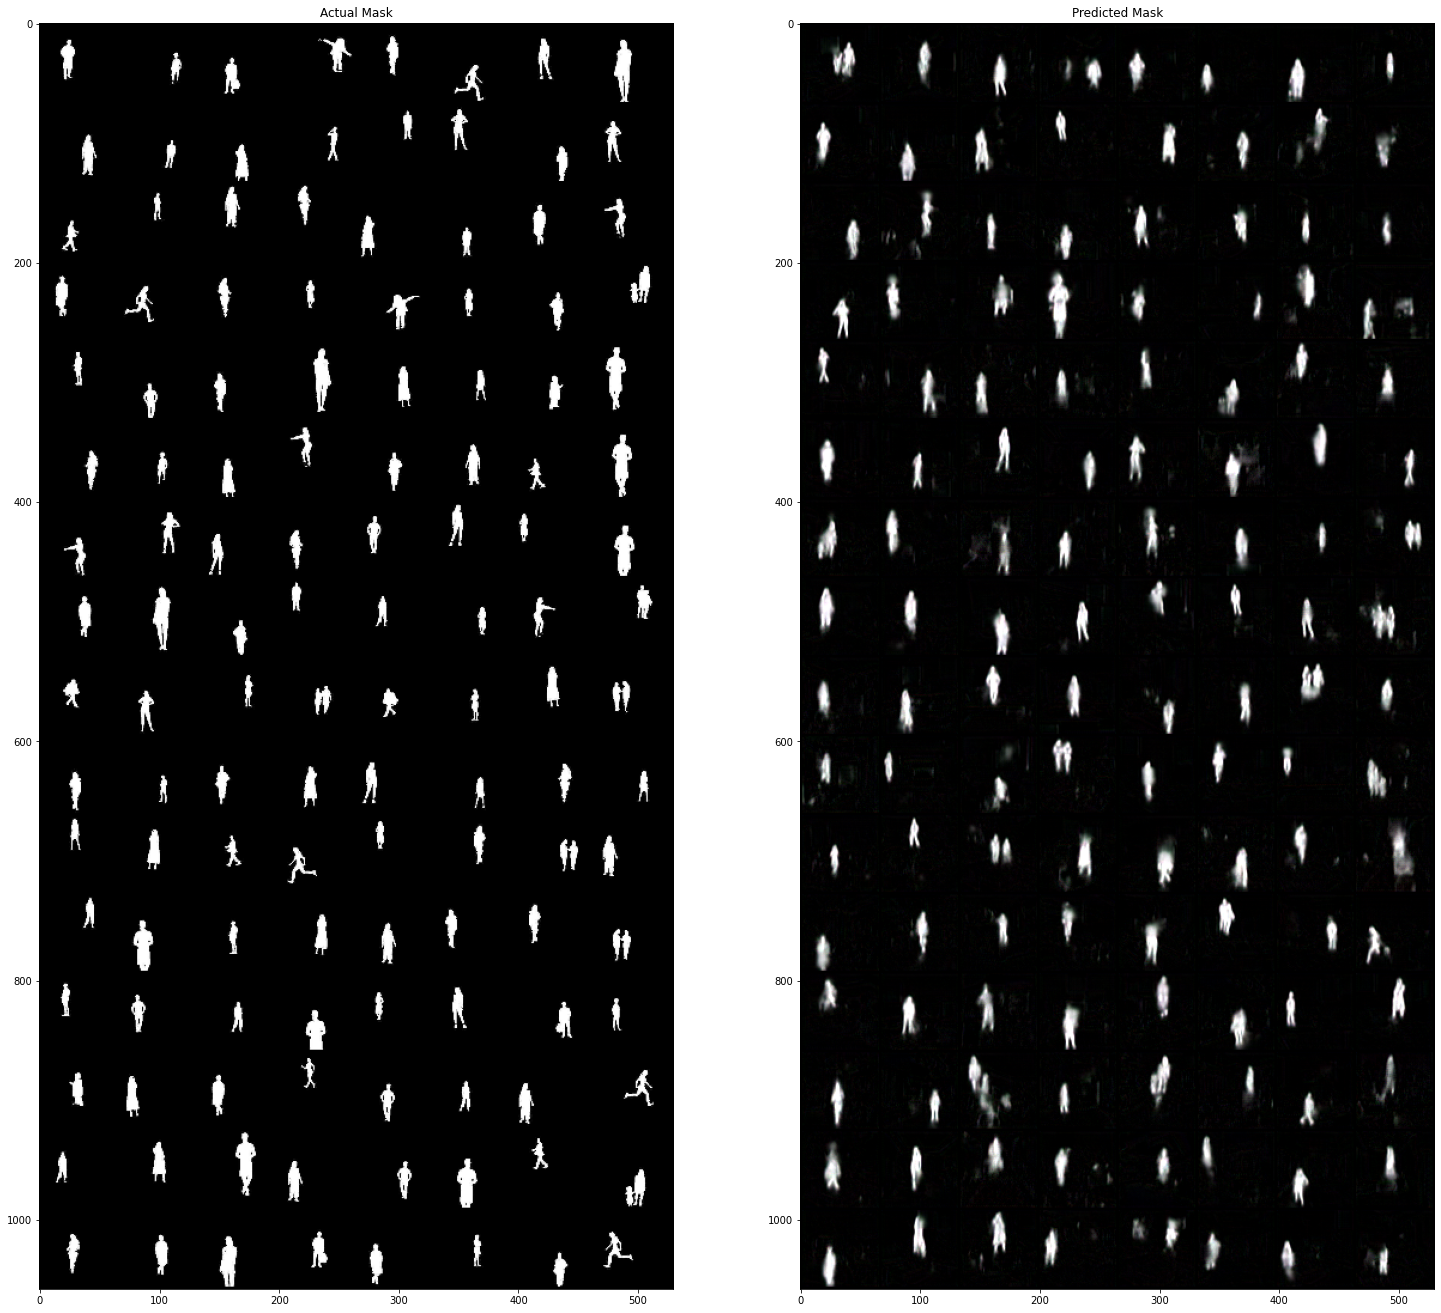

In [24]:
show_images(mask,mask_pred,title='Mask')

In [0]:
# test on test images
test_bg,test_fgbg,test_mask,test_depth = next(iter(testloader))
test_data = torch.cat((test_fgbg,test_bg),1)
test_data = test_data.to(device)
test_predMask,test_predDepth = model(test_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


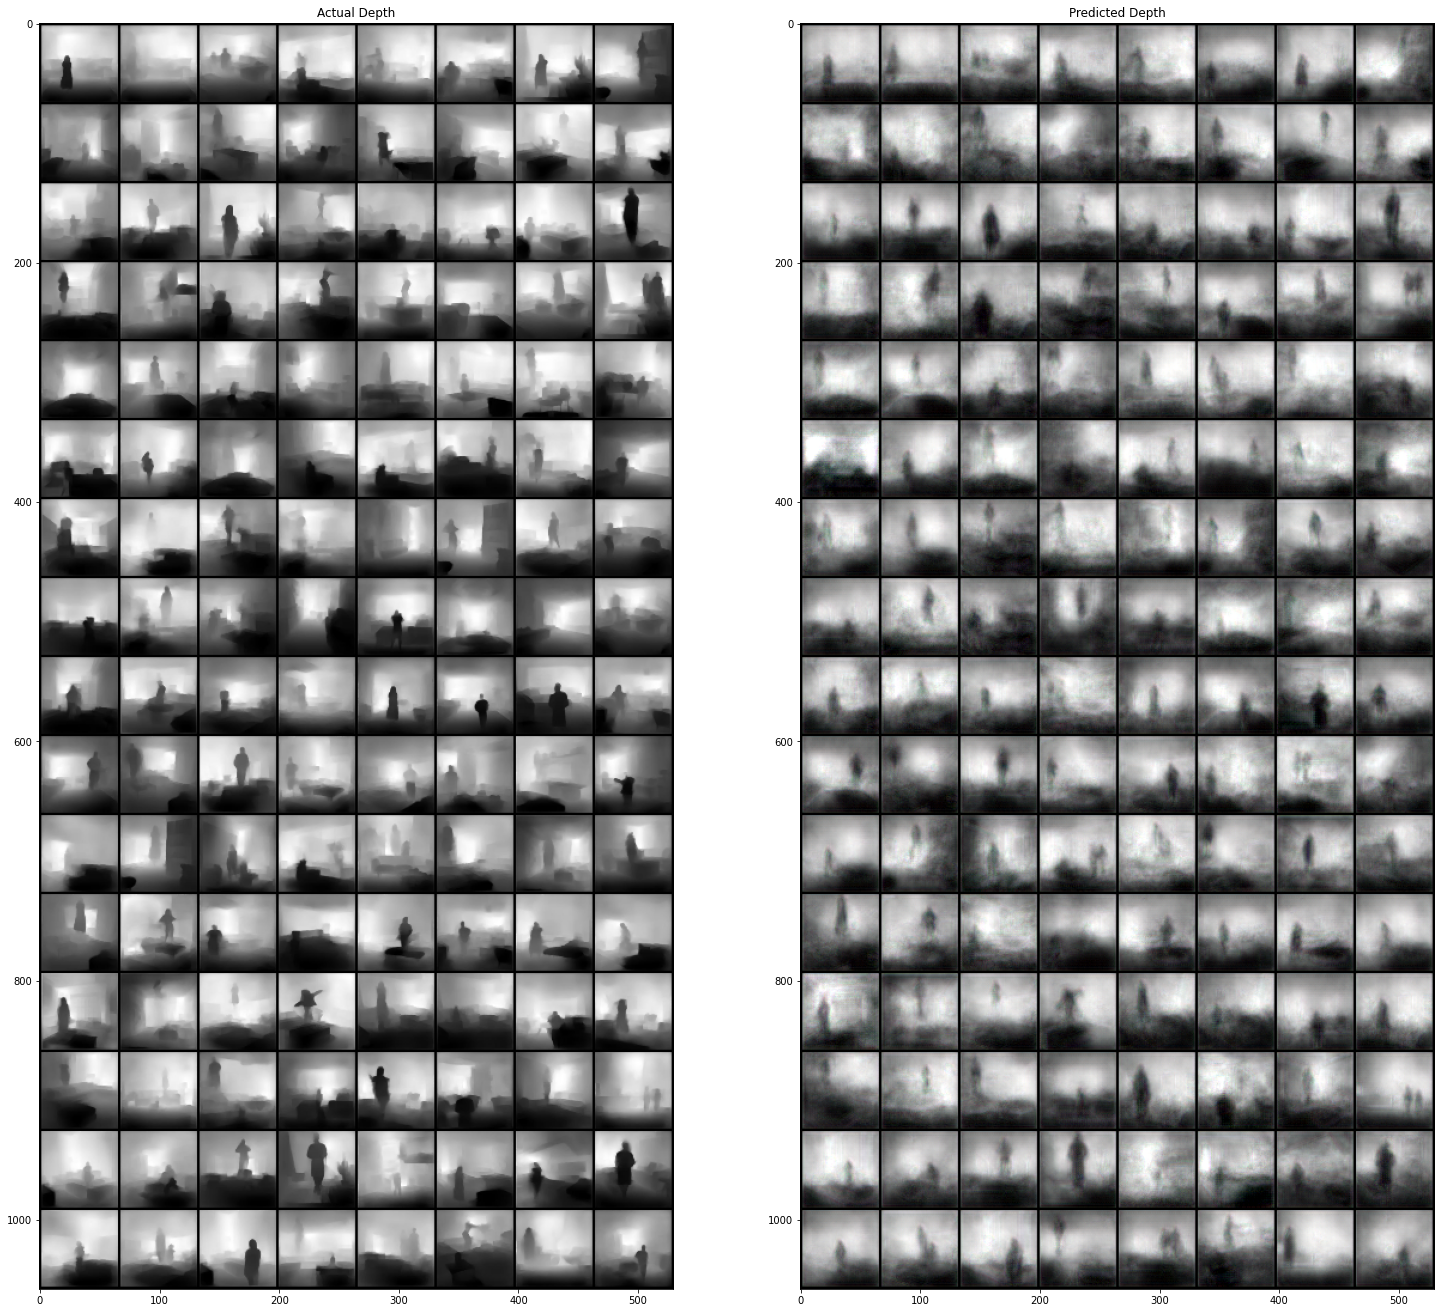

In [26]:
show_images(test_depth,test_predDepth,title='Depth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


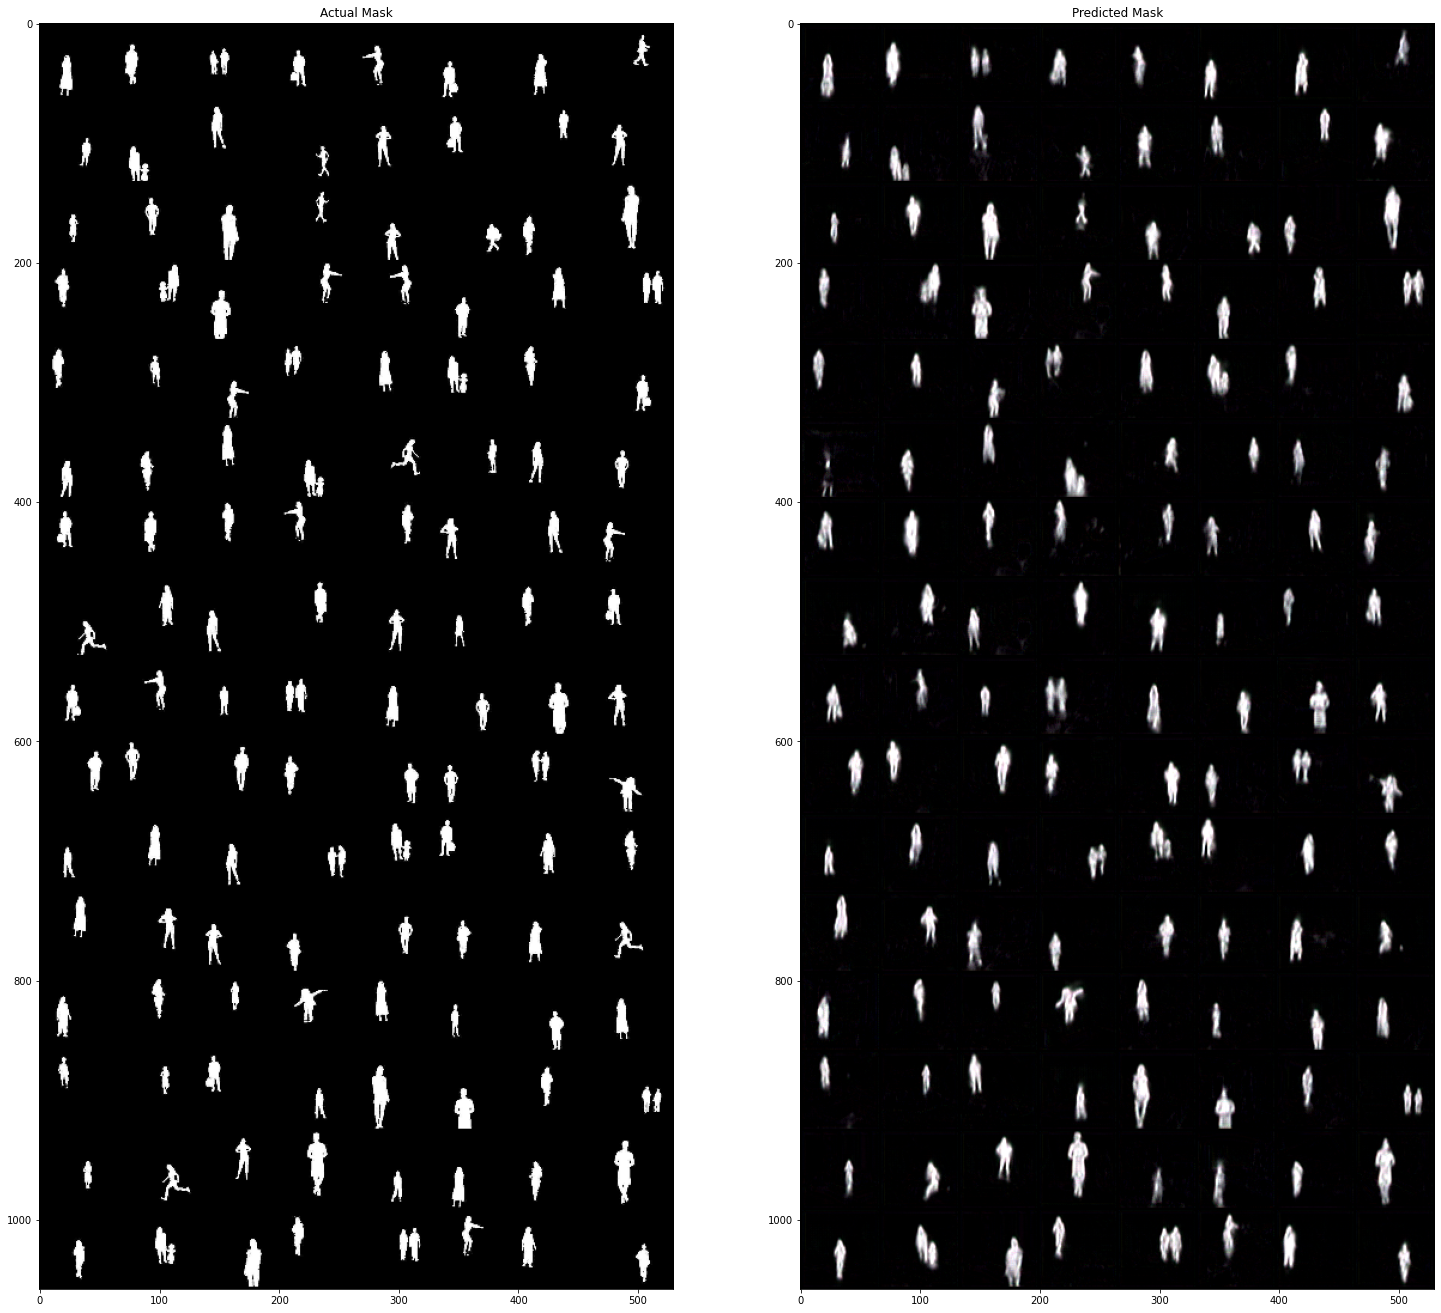

In [27]:
show_images(test_mask,test_predMask,title='Mask')